In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import heapq
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from enum import Enum

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [14]:
class EventType(Enum):
    ARRIVAL = "arrival"
    SERVICE_COMPLETION = "service_completion"
    ABANDON = "abandon"
    CHARGING_COMPLETION = "charging_completion"

@dataclass
class Event:
    time: float
    event_type: EventType
    customer_id: Optional[int] = None
    server_id: Optional[int] = None
    
    def __lt__(self, other):
        return self.time < other.time

@dataclass
class Customer:
    id: int
    arrival_time: float
    service_time: float
    patience_time: float
    
    # Results to be filled during simulation
    queue_length_on_arrival: int = 0
    servers_available_on_arrival: int = 0
    servers_occupied_on_arrival: int = 0  # NEW: servers busy serving customers
    servers_charging_on_arrival: int = 0  # NEW: servers in charging state
    system_size_on_arrival: int = 0  # Total customers in system
    wait_time: float = 0.0
    service_start_time: float = 0.0
    departure_time: float = 0.0
    charging_time: float = 0.0  # Time spent in charging (if applicable)
    abandoned: bool = False

    def get_server_state_summary(self):
        """Get a summary of server states at arrival"""
        total = self.servers_available_on_arrival + self.servers_occupied_on_arrival + self.servers_charging_on_arrival
        return {
            'available': self.servers_available_on_arrival,
            'occupied': self.servers_occupied_on_arrival,
            'charging': self.servers_charging_on_arrival,
            'total': total
        }

class QueueSimulation:
    def __init__(self, num_customers: int, lambda_rate: float, mu_rate: float, 
                 theta_rate: float, num_servers: int, p_charge: float = 0.0, 
                 gamma_rate: float = 1.0, charging_distribution: str = 'exponential',random_seed: int = 2221):
        """
        Initialize queue simulation parameters
        
        Args:
            num_customers: Fixed number of customers to simulate
            lambda_rate: Arrival rate (λ)
            mu_rate: Service rate (μ)
            theta_rate: Abandonment rate (θ)
            num_servers: Total number of servers (c)
            p_charge: Probability of going to charge after service (p)
            gamma_rate: Charging completion rate (γ)
            random_seed: Random seed for reproducibility
        """
        self.num_customers = num_customers
        self.lambda_rate = lambda_rate
        self.mu_rate = mu_rate
        self.theta_rate = theta_rate
        self.num_servers = num_servers
        self.p_charge = p_charge
        self.gamma_rate = gamma_rate
        
        np.random.seed(random_seed)
        
        # Generate all random variables upfront
        self.customers = self._generate_customers()

        # Pre-generate charging decisions for server completions
        # We need more than num_customers because servers can complete multiple services
        max_service_completions = num_customers * 3  # Conservative estimate
        self.charging_decisions = np.random.binomial(1, self.p_charge, max_service_completions)
        #print(self.charging_decisions)
        if charging_distribution == 'exponential':
            self.charging_times = np.random.exponential(1/self.gamma_rate, max_service_completions)
        elif charging_distribution == 'constant':
            self.charging_times = np.ones(max_service_completions) * (1/self.gamma_rate)  # Fixed charging time for simplicity 
        elif charging_distribution == 'uniform':
            self.charging_times = np.random.uniform(0, 2/self.gamma_rate, max_service_completions) #need to fix this
        else:
            raise ValueError(f"Unknown charging distribution: {charging_distribution}")
        #print(self.charging_times)
        self.charging_decision_index = 0
        
    def _generate_customers(self) -> List[Customer]:
        """Generate all customers with their random attributes"""
        customers = []
        
        # Generate inter-arrival times (exponential)
        inter_arrivals = np.random.exponential(1/self.lambda_rate, self.num_customers)
        arrival_times = np.cumsum(inter_arrivals)
        
        # Generate service times (exponential)
        service_times = np.random.exponential(1/self.mu_rate, self.num_customers)
        
        # Generate patience times (exponential)
        patience_times = np.random.exponential(1/self.theta_rate, self.num_customers)
        
        
        for i in range(self.num_customers):
            customer = Customer(
                id=i,
                arrival_time=arrival_times[i],
                service_time=service_times[i],
                patience_time=patience_times[i]
            )
            customers.append(customer)
            
        return customers
    
    def simulate_erlang_a(self) -> List[Customer]:
        """Simulate Erlang-A queue (no charging)"""
        # Initialize state
        event_queue = []
        queue = []  # Waiting customers
        servers = [None] * self.num_servers  # None means idle, customer_id means busy
        current_time = 0.0
        
        # Schedule all arrivals
        for customer in self.customers:
            heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
        
        # Process events
        while event_queue:
            event = heapq.heappop(event_queue)
            current_time = event.time
            
            if event.event_type == EventType.ARRIVAL:
                self._handle_arrival_erlang_a(event, queue, servers, event_queue)
            elif event.event_type == EventType.SERVICE_COMPLETION:
                self._handle_service_completion_erlang_a(event, queue, servers, event_queue)
            elif event.event_type == EventType.ABANDON:
                self._handle_abandon(event, queue)
        
        return self.customers
    
    def simulate_erlang_s(self) -> List[Customer]:
        """Simulate Erlang-S* queue (with charging)"""
        # Initialize state
        event_queue = []
        queue = []  # Waiting customers
        active_servers = list(range(self.num_servers))  # All servers start active
        charging_servers = []  # Servers in charging state
        server_assignments = {}  # server_id -> customer_id
        current_time = 0.0
        
        #print(f"DEBUG: Starting simulation with {self.num_servers} servers")
        #print(f"DEBUG: Initial active_servers: {active_servers}")
        
        # Schedule all arrivals
        for customer in self.customers:
            heapq.heappush(event_queue, Event(customer.arrival_time, EventType.ARRIVAL, customer.id))
        
        # Process events
        while event_queue:
            event = heapq.heappop(event_queue)
            current_time = event.time
            
            if event.event_type == EventType.ARRIVAL:
                self._handle_arrival_erlang_s(event, queue, active_servers, server_assignments, event_queue, charging_servers)
            elif event.event_type == EventType.SERVICE_COMPLETION:
                self._handle_service_completion_erlang_s(event, queue, active_servers, charging_servers, 
                                                    server_assignments, event_queue)
            elif event.event_type == EventType.ABANDON:
                self._handle_abandon(event, queue)
            elif event.event_type == EventType.CHARGING_COMPLETION:
                # Pass all necessary parameters for serving waiting customers
                self._handle_charging_completion(event, active_servers, charging_servers, 
                                            queue, server_assignments, event_queue)
        
        #print(f"DEBUG: Final state - active: {len(active_servers)}, charging: {len(charging_servers)}, occupied: {len(server_assignments)}")
        return self.customers

    # Update the arrival handler to accept charging_servers
    def _handle_arrival_erlang_s(self, event, queue, active_servers, server_assignments, event_queue, charging_servers):
        customer = self.customers[event.customer_id]
        customer.queue_length_on_arrival = len(queue)
        
        # Track server states for Erlang-S*
        available_servers = len(active_servers)
        occupied_servers = len(server_assignments)
        charging_servers_count = len(charging_servers)
        
        customer.servers_available_on_arrival = available_servers
        customer.servers_occupied_on_arrival = occupied_servers
        customer.servers_charging_on_arrival = charging_servers_count
        
        # Verify server count consistency
        total_tracked = available_servers + occupied_servers + charging_servers_count
        if total_tracked != self.num_servers:
            print(f"DEBUG WARNING: Server count mismatch at time {event.time:.3f}")
            print(f"  Available: {available_servers}, Occupied: {occupied_servers}, Charging: {charging_servers_count}")
            print(f"  Total: {total_tracked}, Expected: {self.num_servers}")
        
        # Calculate total customers in system (queue + being served)
        customers_being_served = occupied_servers
        customer.system_size_on_arrival = len(queue) + customers_being_served
        
        if active_servers:
            # Start service immediately
            server_id = active_servers.pop(0)
            server_assignments[server_id] = customer.id
            customer.service_start_time = event.time
            customer.wait_time = 0.0
            
            # Schedule service completion
            completion_time = event.time + customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            customer.id, server_id))
        else:
            # Join queue and schedule abandonment
            queue.append(customer.id)
            abandon_time = event.time + customer.patience_time
            heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))
        
    def _handle_arrival_erlang_a(self, event, queue, servers, event_queue):
        customer = self.customers[event.customer_id]
        customer.queue_length_on_arrival = len(queue)
        
        # Track server states for Erlang-A
        available_servers = sum(1 for s in servers if s is None)
        occupied_servers = sum(1 for s in servers if s is not None)
        
        customer.servers_available_on_arrival = available_servers
        customer.servers_occupied_on_arrival = occupied_servers
        customer.servers_charging_on_arrival = 0  # No charging in Erlang-A
        
        # Calculate total customers in system (queue + being served)
        customers_being_served = occupied_servers
        customer.system_size_on_arrival = len(queue) + customers_being_served
        
        # Check if server is available
        available_server = None
        for i, server in enumerate(servers):
            if server is None:
                available_server = i
                break
        
        if available_server is not None:
            # Start service immediately
            servers[available_server] = customer.id
            customer.service_start_time = event.time
            customer.wait_time = 0.0
            
            # Schedule service completion
            completion_time = event.time + customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            customer.id, available_server))
        else:
            # Join queue and schedule abandonment
            queue.append(customer.id)
            abandon_time = event.time + customer.patience_time
            heapq.heappush(event_queue, Event(abandon_time, EventType.ABANDON, customer.id))

    def _handle_charging_completion(self, event, active_servers, charging_servers, queue=None, server_assignments=None, event_queue=None):
        """Handle server charging completion - move server back to active and serve waiting customers"""
        server_id = event.server_id
        if server_id in charging_servers:
            charging_servers.remove(server_id)
            
            # Check if there are waiting customers in queue
            if queue and len(queue) > 0 and server_assignments is not None and event_queue is not None:
                # Immediately serve next customer instead of going to active list
                next_customer_id = queue.pop(0)
                next_customer = self.customers[next_customer_id]
                
                # Assign server to customer
                server_assignments[server_id] = next_customer_id
                next_customer.service_start_time = event.time
                next_customer.wait_time = event.time - next_customer.arrival_time
                
                # Schedule service completion
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, server_id))
                
                #print(f"DEBUG: Server {server_id} finished charging at time {event.time:.3f} and immediately serves customer {next_customer_id}")
            else:
                # No waiting customers, add to active servers
                active_servers.append(server_id)
                #print(f"DEBUG: Server {server_id} finished charging at time {event.time:.3f} and becomes available")
            
            #print(f"DEBUG: Active servers now: {active_servers}")
            #print(f"DEBUG: Charging servers now: {charging_servers}")
        else:
            print(f"DEBUG: ERROR - Server {server_id} not found in charging_servers at time {event.time:.3f}")
            print(f"DEBUG: Current charging_servers: {charging_servers}")
            print(f"DEBUG: Current active_servers: {active_servers}")

    
    def _handle_service_completion_erlang_a(self, event, queue, servers, event_queue):
        customer = self.customers[event.customer_id]
        customer.departure_time = event.time
        servers[event.server_id] = None
        
        # Check if there's a waiting customer
        if queue:
            next_customer_id = queue.pop(0)
            next_customer = self.customers[next_customer_id]
            
            # Remove abandonment event for this customer (if it exists)
            # Note: In a more sophisticated implementation, we'd track and remove the event
            
            # Start service for next customer
            servers[event.server_id] = next_customer_id
            next_customer.service_start_time = event.time
            next_customer.wait_time = event.time - next_customer.arrival_time
            
            # Schedule service completion
            completion_time = event.time + next_customer.service_time
            heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                            next_customer_id, event.server_id))
    
    def _handle_service_completion_erlang_s(self, event, queue, active_servers, charging_servers, server_assignments, event_queue):
        """Handle service completion in Erlang-S* system"""
        customer = self.customers[event.customer_id]
        customer.departure_time = event.time
        
        # Remove server from assignments
        if event.server_id in server_assignments:
            del server_assignments[event.server_id]
        else:
            print(f"DEBUG: WARNING - Server {event.server_id} not found in assignments")
        
        #print(f"DEBUG: Service completion for customer {customer.id} by server {event.server_id} at time {event.time:.3f}")
        #print(f"DEBUG: Queue length: {len(queue)}")
        
        # EVERY service completion should have a charging decision
        if self.charging_decision_index < len(self.charging_decisions):
            server_goes_to_charge = bool(self.charging_decisions[self.charging_decision_index])
            server_charging_time = self.charging_times[self.charging_decision_index]
            self.charging_decision_index += 1
            
            #print(f"DEBUG: Server {event.server_id} charging decision: {server_goes_to_charge}")
            
            if server_goes_to_charge:
                # Server goes to charging regardless of queue status
                charging_servers.append(event.server_id)
                #print(f"DEBUG: Server {event.server_id} starts charging for {server_charging_time:.3f} time units")
                
                # Schedule charging completion
                charging_completion_time = event.time + server_charging_time
                customer.charging_time = server_charging_time  # Record charging time for the customer
                heapq.heappush(event_queue, Event(charging_completion_time, EventType.CHARGING_COMPLETION, 
                                                None, event.server_id))
                #print(f"DEBUG: Charging completion scheduled for time {charging_completion_time:.3f}")
                
                # If there are waiting customers, they wait for this server to finish charging
                # OR other available servers can serve them
                
            else:
                # Server doesn't go charging, check if there are waiting customers
                if queue:
                    next_customer_id = queue.pop(0)
                    next_customer = self.customers[next_customer_id]
                    
                    # Use the same server that just finished
                    server_assignments[event.server_id] = next_customer_id
                    next_customer.service_start_time = event.time
                    next_customer.wait_time = event.time - next_customer.arrival_time
                    
                    #print(f"DEBUG: Server {event.server_id} immediately serves next customer {next_customer_id}")
                    
                    # Schedule service completion
                    completion_time = event.time + next_customer.service_time
                    heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                    next_customer_id, event.server_id))
                else:
                    # No waiting customers, server becomes available
                    active_servers.append(event.server_id)
                    #print(f"DEBUG: Server {event.server_id} becomes immediately available")
        else:
            # Fallback if we run out of pre-generated decisions
            if queue:
                next_customer_id = queue.pop(0)
                next_customer = self.customers[next_customer_id]
                server_assignments[event.server_id] = next_customer_id
                next_customer.service_start_time = event.time
                next_customer.wait_time = event.time - next_customer.arrival_time
                completion_time = event.time + next_customer.service_time
                heapq.heappush(event_queue, Event(completion_time, EventType.SERVICE_COMPLETION, 
                                                next_customer_id, event.server_id))
            else:
                active_servers.append(event.server_id)
                #print(f"DEBUG: Server {event.server_id} becomes available (no more charging decisions)")
        
        #print(f"DEBUG: After service completion - Active: {len(active_servers)}, Charging: {len(charging_servers)}, Occupied: {len(server_assignments)}")
        
    def _handle_abandon(self, event, queue):
        customer_id = event.customer_id
        if customer_id in queue:
            queue.remove(customer_id)
            customer = self.customers[customer_id]
            customer.abandoned = True
            customer.wait_time = event.time - customer.arrival_time
            customer.departure_time = event.time
    
    # def _handle_charging_completion(self, event, active_servers, charging_servers):
    #     server_id = event.server_id
    #     if server_id in charging_servers:
    #         charging_servers.remove(server_id)
    #         active_servers.append(server_id)


In [15]:
def analyze_and_visualize(customers_a: List[Customer], customers_s: List[Customer], 
                         params: Dict, save_plots: bool = False):
    """Analyze simulation results and create visualizations"""
    
    # Create DataFrames for analysis
    df_a = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-A'
    } for c in customers_a])
    
    df_s = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-S*'
    } for c in customers_s])
    
    df_combined = pd.concat([df_a, df_s], ignore_index=True)
    
    # Print summary statistics
    print("=== SIMULATION RESULTS ===")
    print(f"Parameters: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, c={params['c']}")
    print(f"Erlang-S* specific: p={params['p']}, γ={params['gamma']}")
    print("\nERLANG-A QUEUE:")
    print(f"  Average wait time: {df_a['wait_time'].mean():.3f}")
    print(f"  Average queue length on arrival: {df_a['queue_length_on_arrival'].mean():.3f}")
    print(f"  Abandonment rate: {df_a['abandoned'].mean():.3f}")
    print(f"  Average servers available on arrival: {df_a['servers_available_on_arrival'].mean():.3f}")
    
    print("\nERLANG-S* QUEUE:")
    print(f"  Average wait time: {df_s['wait_time'].mean():.3f}")
    print(f"  Average queue length on arrival: {df_s['queue_length_on_arrival'].mean():.3f}")
    print(f"  Abandonment rate: {df_s['abandoned'].mean():.3f}")
    print(f"  Average servers available on arrival: {df_s['servers_available_on_arrival'].mean():.3f}")
    
    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Wait Time Distributions
    plt.subplot(3, 4, 1)
    non_abandoned_a = df_a[~df_a['abandoned']]['wait_time']
    non_abandoned_s = df_s[~df_s['abandoned']]['wait_time']
    
    plt.hist(non_abandoned_a, alpha=0.7, bins=30, label='Erlang-A', density=True)
    plt.hist(non_abandoned_s, alpha=0.7, bins=30, label='Erlang-S*', density=True)
    plt.xlabel('Wait Time')
    plt.ylabel('Density')
    plt.title('Wait Time Distribution\n(Non-abandoned customers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Queue Length on Arrival
    plt.subplot(3, 4, 2)
    queue_lengths_a = df_a['queue_length_on_arrival'].value_counts().sort_index()
    queue_lengths_s = df_s['queue_length_on_arrival'].value_counts().sort_index()
    
    x_pos = np.arange(max(queue_lengths_a.index.max(), queue_lengths_s.index.max()) + 1)
    plt.bar(x_pos - 0.2, [queue_lengths_a.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-A')
    plt.bar(x_pos + 0.2, [queue_lengths_s.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-S*')
    plt.xlabel('Queue Length on Arrival')
    plt.ylabel('Frequency')
    plt.title('Queue Length Distribution\n(On Arrival)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Servers Available on Arrival
    plt.subplot(3, 4, 3)
    servers_a = df_a['servers_available_on_arrival'].value_counts().sort_index()
    servers_s = df_s['servers_available_on_arrival'].value_counts().sort_index()
    
    x_pos = np.arange(params['c'] + 1)
    plt.bar(x_pos - 0.2, [servers_a.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-A')
    plt.bar(x_pos + 0.2, [servers_s.get(i, 0) for i in x_pos], 
            width=0.4, alpha=0.7, label='Erlang-S*')
    plt.xlabel('Servers Available on Arrival')
    plt.ylabel('Frequency')
    plt.title('Available Servers Distribution\n(On Arrival)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Abandonment Comparison
    plt.subplot(3, 4, 4)
    abandon_rates = [df_a['abandoned'].mean(), df_s['abandoned'].mean()]
    systems = ['Erlang-A', 'Erlang-S*']
    colors = ['#1f77b4', '#ff7f0e']
    
    bars = plt.bar(systems, abandon_rates, color=colors, alpha=0.7)
    plt.ylabel('Abandonment Rate')
    plt.title('Abandonment Rate Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, abandon_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{rate:.3f}', ha='center', va='bottom')
    
    # 5. Wait Time Over Time
    plt.subplot(3, 4, 5)
    window_size = max(50, len(customers_a) // 20)
    df_a_sorted = df_a.sort_values('arrival_time')
    df_s_sorted = df_s.sort_values('arrival_time')
    
    wait_time_ma_a = df_a_sorted['wait_time'].rolling(window=window_size, center=True).mean()
    wait_time_ma_s = df_s_sorted['wait_time'].rolling(window=window_size, center=True).mean()
    
    plt.plot(df_a_sorted['arrival_time'], wait_time_ma_a, label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], wait_time_ma_s, label='Erlang-S*', alpha=0.8)
    plt.xlabel('Arrival Time')
    plt.ylabel('Wait Time (Moving Average)')
    plt.title(f'Wait Time Evolution\n(Moving Average, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Service Time vs Wait Time Scatter
    plt.subplot(3, 4, 6)
    non_abandoned_a = df_a[~df_a['abandoned']]
    non_abandoned_s = df_s[~df_s['abandoned']]
    
    plt.scatter(non_abandoned_a['service_time'], non_abandoned_a['wait_time'], 
               alpha=0.5, label='Erlang-A', s=20)
    plt.scatter(non_abandoned_s['service_time'], non_abandoned_s['wait_time'], 
               alpha=0.5, label='Erlang-S*', s=20)
    plt.xlabel('Service Time')
    plt.ylabel('Wait Time')
    plt.title('Service Time vs Wait Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Queue Length Evolution
    plt.subplot(3, 4, 7)
    plt.plot(df_a_sorted['arrival_time'], 
             df_a_sorted['queue_length_on_arrival'].rolling(window=window_size, center=True).mean(),
             label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], 
             df_s_sorted['queue_length_on_arrival'].rolling(window=window_size, center=True).mean(),
             label='Erlang-S*', alpha=0.8)
    plt.xlabel('Arrival Time')
    plt.ylabel('Queue Length (Moving Average)')
    plt.title(f'Queue Length Evolution\n(Moving Average, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Wait Time Box Plot
    plt.subplot(3, 4, 8)
    wait_data = [non_abandoned_a['wait_time'], non_abandoned_s['wait_time']]
    plt.boxplot(wait_data, labels=['Erlang-A', 'Erlang-S*'])
    plt.ylabel('Wait Time')
    plt.title('Wait Time Distribution\n(Box Plot)')
    plt.grid(True, alpha=0.3)
    
    # 9. Probability of Delay (P(Wait > 0))
    plt.subplot(3, 4, 9)
    delay_prob_a = (df_a['wait_time'] > 0).sum() / len(customers_a)
    delay_prob_s = (df_s['wait_time'] > 0).sum() / len(customers_s)
    
    bars = plt.bar(['Erlang-A', 'Erlang-S*'], [delay_prob_a, delay_prob_s], 
                   color=colors, alpha=0.7)
    plt.ylabel('Probability of Delay')
    plt.title('Probability of Delay\nP(Wait Time > 0)')
    plt.grid(True, alpha=0.3)
    
    for bar, prob in zip(bars, [delay_prob_a, delay_prob_s]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{prob:.3f}', ha='center', va='bottom')
  
    
    # 10. System Time Distribution (Wait + Service)
    plt.subplot(3, 4, 10)
    system_time_a = non_abandoned_a['wait_time'] + non_abandoned_a['service_time']
    system_time_s = non_abandoned_s['wait_time'] + non_abandoned_s['service_time']
    
    plt.hist(system_time_a, alpha=0.7, bins=30, label='Erlang-A', density=True)
    plt.hist(system_time_s, alpha=0.7, bins=30, label='Erlang-S*', density=True)
    plt.xlabel('System Time (Wait + Service)')
    plt.ylabel('Density')
    plt.title('System Time Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 11. Utilization Over Time (approximation)
    plt.subplot(3, 4, 11)
    busy_servers_a = params['c'] - df_a_sorted['servers_available_on_arrival']
    busy_servers_s = params['c'] - df_s_sorted['servers_available_on_arrival']
    
    utilization_a = busy_servers_a.rolling(window=window_size, center=True).mean() / params['c']
    utilization_s = busy_servers_s.rolling(window=window_size, center=True).mean() / params['c']
    
    plt.plot(df_a_sorted['arrival_time'], utilization_a, label='Erlang-A', alpha=0.8)
    plt.plot(df_s_sorted['arrival_time'], utilization_s, label='Erlang-S*', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel('Utilization (approx)')
    plt.title('Server Utilization Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 12. Performance Metrics Summary
    plt.subplot(3, 4, 12)
    metrics = ['Avg Wait Time', 'Abandonment Rate', 'Delay Probability', 'Avg Queue Length']
    erlang_a_metrics = [
        df_a['wait_time'].mean(),
        df_a['abandoned'].mean(),
        delay_prob_a,
        df_a['queue_length_on_arrival'].mean()
    ]
    erlang_s_metrics = [
        df_s['wait_time'].mean(),
        df_s['abandoned'].mean(),
        delay_prob_s,
        df_s['queue_length_on_arrival'].mean()
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, erlang_a_metrics, width, label='Erlang-A', alpha=0.7)
    plt.bar(x + width/2, erlang_s_metrics, width, label='Erlang-S*', alpha=0.7)
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('queue_simulation_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return df_combined

In [16]:
def delay_probability(customers_a: List[Customer], customers_s: List[Customer], params: Dict):
    """
    Calculate the probability of delay (waiting time > 0) for all customers.
    
    Args:
        customers_a: List of Customer objects from Erlang-A
        customers_s: List of Customer objects from Erlang-S*
        params: Dictionary of parameters
    
    Returns:
        Tuple of delay probabilities (Erlang-A, Erlang-S*)
    """
    # Create DataFrames for analysis
    df_a = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-A'
    } for c in customers_a])
    
    df_s = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'departure_time': c.departure_time,
        'abandoned': c.abandoned,
        'system': 'Erlang-S*'
    } for c in customers_s])
    
    # colors = ['#1f77b4', '#ff7f0e']
    
    # plt.figure(figsize=(5, 4))
    
    # # FIXED: Calculate delay probability correctly
    delay_prob_a = (df_a['wait_time'] > 0).sum() / len(customers_a)
    delay_prob_s = (df_s['wait_time'] > 0).sum() / len(customers_s)

    abandoned_a = df_a['abandoned'].mean()
    abandoned_s = df_s['abandoned'].mean()
    
    # bars = plt.bar(['Erlang-A', 'Erlang-S*'], [delay_prob_a, delay_prob_s], 
    #                color=colors, alpha=0.7)
    # plt.ylabel('Probability of Delay')
    # plt.title('Probability of Delay\nP(Wait Time > 0)')
    # plt.grid(True, alpha=0.3)
    
    # # Add value labels on bars
    # for bar, prob in zip(bars, [delay_prob_a, delay_prob_s]):
    #     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
    #             f'{prob:.3f}', ha='center', va='bottom')
    
    # plt.show()
    
    return delay_prob_a, delay_prob_s, abandoned_a, abandoned_s

In [6]:
if __name__ == "__main__":
    # Simulation parameters
    params = {
        'lambda': 10.0,    # Arrival rate
        'mu': 1,        # Service rate  
        'theta': 1,     # Abandonment rate
        'c': 10,           # Number of servers
        'p': 0.5,         # Probability of going to charge (Erlang-S* only)
        'gamma': 1      # Charging completion rate (Erlang-S* only)
    }
    
    num_customers = int(10e3)
    
    print("Starting queue simulations...")
    print(f"Simulating {num_customers} customers with parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Run Erlang-A simulation
    print("\nRunning Erlang-A simulation...")
    sim_a = QueueSimulation(
        num_customers=num_customers,
        lambda_rate=params['lambda'],
        mu_rate=params['mu'],
        theta_rate=params['theta'],
        num_servers=params['c'],
        p_charge=0.0,  # No charging in Erlang-A
        gamma_rate=params['gamma'],
        charging_distribution= 'exponential'
    )
    customers_a = sim_a.simulate_erlang_a()
    
    # Run Erlang-S* simulation
    print("Running Erlang-S* simulation...")
    sim_s = QueueSimulation(
        num_customers=num_customers,
        lambda_rate=params['lambda'],
        mu_rate=params['mu'],
        theta_rate=params['theta'],
        num_servers=params['c'],
        p_charge=params['p'],
        gamma_rate=params['gamma'],
        charging_distribution= 'exponential'
    )
    customers_s = sim_s.simulate_erlang_s()
    
    # Analyze and visualize results
    print("Analyzing results and creating visualizations...")
    #df_results = analyze_and_visualize(customers_a, customers_s, params, save_plots=True)
    df_delay = delay_probability(customers_a, customers_s, params)
    print(df_delay)
    print("\nSimulation completed! Check the generated plots for detailed analysis.")

Starting queue simulations...
Simulating 10000 customers with parameters:
  lambda: 10.0
  mu: 1
  theta: 1
  c: 10
  p: 0.5
  gamma: 1

Running Erlang-A simulation...
Running Erlang-S* simulation...
Analyzing results and creating visualizations...
(0.5225, 0.8793, 0.126, 0.3395)

Simulation completed! Check the generated plots for detailed analysis.


In [17]:
import pickle
import os
from datetime import datetime

def save_simulation_results(customers_a, customers_s, df_delay, params, 
                           save_dir="simulation_results", 
                           filename_prefix="sim_results"):
    """
    Save simulation results in multiple formats for later analysis
    
    Args:
        customers_a: List of Customer objects from Erlang-A simulation
        customers_s: List of Customer objects from Erlang-S* simulation  
        df_delay: Tuple containing delay probabilities and abandonment rates
        params: Dictionary of simulation parameters
        save_dir: Directory to save results
        filename_prefix: Prefix for saved files
    
    Returns:
        dict: Dictionary containing file paths of saved results
    """
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare results dictionary
    results = {
        'params': params,
        'timestamp': timestamp,
        'num_customers': len(customers_a),
        'customers_a': customers_a,
        'customers_s': customers_s,
        'delay_results': {
            'delay_prob_a': df_delay[0],
            'delay_prob_s': df_delay[1], 
            'abandoned_a': df_delay[2],
            'abandoned_s': df_delay[3]
        }
    }
    
    # Convert customers to DataFrames for easier analysis
    df_a = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'servers_occupied_on_arrival': c.servers_occupied_on_arrival,
        'servers_charging_on_arrival': c.servers_charging_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'service_start_time': c.service_start_time,
        'departure_time': c.departure_time,
        'charging_time': c.charging_time,
        'abandoned': c.abandoned,
        'patience_time': c.patience_time,
        'system': 'Erlang-A'
    } for c in customers_a])
    
    df_s = pd.DataFrame([{
        'customer_id': c.id,
        'arrival_time': c.arrival_time,
        'queue_length_on_arrival': c.queue_length_on_arrival,
        'system_size_on_arrival': c.system_size_on_arrival,
        'servers_available_on_arrival': c.servers_available_on_arrival,
        'servers_occupied_on_arrival': c.servers_occupied_on_arrival,
        'servers_charging_on_arrival': c.servers_charging_on_arrival,
        'wait_time': c.wait_time,
        'service_time': c.service_time,
        'service_start_time': c.service_start_time,
        'departure_time': c.departure_time,
        'charging_time': c.charging_time,
        'abandoned': c.abandoned,
        'patience_time': c.patience_time,
        'system': 'Erlang-S*'
    } for c in customers_s])
    
    # Add DataFrames to results
    results['df_erlang_a'] = df_a
    results['df_erlang_s'] = df_s
    results['df_combined'] = pd.concat([df_a, df_s], ignore_index=True)
    
    # File paths
    files_saved = {}
    
    # 1. Save complete results as pickle (most comprehensive)
    pickle_file = os.path.join(save_dir, f"{filename_prefix}_{timestamp}.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump(results, f)
    files_saved['pickle'] = pickle_file
    
    # 2. Save DataFrames as CSV (for easy access in other tools)
    csv_a_file = os.path.join(save_dir, f"{filename_prefix}_erlang_a_{timestamp}.csv")
    csv_s_file = os.path.join(save_dir, f"{filename_prefix}_erlang_s_{timestamp}.csv")
    csv_combined_file = os.path.join(save_dir, f"{filename_prefix}_combined_{timestamp}.csv")
    
    df_a.to_csv(csv_a_file, index=False)
    df_s.to_csv(csv_s_file, index=False)
    results['df_combined'].to_csv(csv_combined_file, index=False)
    
    files_saved['csv_erlang_a'] = csv_a_file
    files_saved['csv_erlang_s'] = csv_s_file
    files_saved['csv_combined'] = csv_combined_file
    
    # 3. Save summary statistics as JSON
    summary_stats = {
        'simulation_params': params,
        'timestamp': timestamp,
        'total_customers': len(customers_a),
        'erlang_a_stats': {
            'avg_wait_time': float(df_a['wait_time'].mean()),
            'avg_queue_length': float(df_a['queue_length_on_arrival'].mean()),
            'abandonment_rate': float(df_a['abandoned'].mean()),
            'delay_probability': float(df_delay[0]),
            'avg_servers_available': float(df_a['servers_available_on_arrival'].mean()),
            'avg_system_size': float(df_a['system_size_on_arrival'].mean())
        },
        'erlang_s_stats': {
            'avg_wait_time': float(df_s['wait_time'].mean()),
            'avg_queue_length': float(df_s['queue_length_on_arrival'].mean()),
            'abandonment_rate': float(df_s['abandoned'].mean()),
            'delay_probability': float(df_delay[1]),
            'avg_servers_available': float(df_s['servers_available_on_arrival'].mean()),
            'avg_servers_charging': float(df_s['servers_charging_on_arrival'].mean()),
            'avg_system_size': float(df_s['system_size_on_arrival'].mean()),
            'avg_charging_time': float(df_s[df_s['charging_time'] > 0]['charging_time'].mean()) if (df_s['charging_time'] > 0).any() else 0.0
        }
    }
    
    import json
    json_file = os.path.join(save_dir, f"{filename_prefix}_summary_{timestamp}.json")
    with open(json_file, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    files_saved['json_summary'] = json_file
    
    # 4. Save parameters separately for easy reference
    params_file = os.path.join(save_dir, f"{filename_prefix}_params_{timestamp}.json")
    with open(params_file, 'w') as f:
        json.dump(params, f, indent=2)
    files_saved['params'] = params_file
    
    # Print summary
    print(f"\n=== SIMULATION RESULTS SAVED ===")
    print(f"Save directory: {save_dir}")
    print(f"Timestamp: {timestamp}")
    print(f"Files saved:")
    for file_type, file_path in files_saved.items():
        print(f"  {file_type}: {os.path.basename(file_path)}")
    
    print(f"\nQuick summary:")
    print(f"  Total customers simulated: {len(customers_a):,}")
    print(f"  Erlang-A delay probability: {df_delay[0]:.4f}")
    print(f"  Erlang-S* delay probability: {df_delay[1]:.4f}")
    print(f"  Erlang-A abandonment rate: {df_delay[2]:.4f}")
    print(f"  Erlang-S* abandonment rate: {df_delay[3]:.4f}")
    
    return files_saved, results

# Function to load saved results
def load_simulation_results(pickle_file_path):
    """
    Load previously saved simulation results
    
    Args:
        pickle_file_path: Path to the pickle file containing results
        
    Returns:
        dict: Dictionary containing all simulation results
    """
    with open(pickle_file_path, 'rb') as f:
        results = pickle.load(f)
    
    print(f"Loaded simulation results from: {pickle_file_path}")
    print(f"Simulation timestamp: {results['timestamp']}")
    print(f"Parameters: {results['params']}")
    print(f"Number of customers: {results['num_customers']:,}")
    
    return results

print("Simulation save/load functions defined successfully!")

Simulation save/load functions defined successfully!


In [8]:
# Save the simulation results from your current run
print("Saving current simulation results...")

# Make sure customers_a, customers_s, df_delay, and params are available from your previous run
files_saved, saved_results = save_simulation_results(
    customers_a=customers_a,
    customers_s=customers_s, 
    df_delay=df_delay,
    params=params,
    save_dir="simulation_results",
    filename_prefix="drone_delivery_queue"
)

print("\nResults saved successfully!")
print(f"Main pickle file: {files_saved['pickle']}")

Saving current simulation results...

=== SIMULATION RESULTS SAVED ===
Save directory: simulation_results
Timestamp: 20250717_175429
Files saved:
  pickle: drone_delivery_queue_20250717_175429.pkl
  csv_erlang_a: drone_delivery_queue_erlang_a_20250717_175429.csv
  csv_erlang_s: drone_delivery_queue_erlang_s_20250717_175429.csv
  csv_combined: drone_delivery_queue_combined_20250717_175429.csv
  json_summary: drone_delivery_queue_summary_20250717_175429.json
  params: drone_delivery_queue_params_20250717_175429.json

Quick summary:
  Total customers simulated: 10,000
  Erlang-A delay probability: 0.5225
  Erlang-S* delay probability: 0.8793
  Erlang-A abandonment rate: 0.1260
  Erlang-S* abandonment rate: 0.3395

Results saved successfully!
Main pickle file: simulation_results/drone_delivery_queue_20250717_175429.pkl


In [21]:
def run_parameter_sweep(parameter_sets, num_customers=10000, base_save_dir="simulation_results"):
    """
    Run multiple simulations with different parameter sets
    
    Args:
        parameter_sets: List of parameter dictionaries
        num_customers: Number of customers per simulation
        base_save_dir: Base directory to save results
    
    Returns:
        List of results summaries
    """
    import os
    from datetime import datetime
    
    # Create a timestamped folder for this parameter sweep
    sweep_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    sweep_dir = os.path.join(base_save_dir, f"parameter_sweep_{sweep_timestamp}")
    os.makedirs(sweep_dir, exist_ok=True)
    
    # Create subdirectories for organization
    individual_runs_dir = os.path.join(sweep_dir, "individual_runs")
    summary_dir = os.path.join(sweep_dir, "summary")
    os.makedirs(individual_runs_dir, exist_ok=True)
    os.makedirs(summary_dir, exist_ok=True)
    
    all_results = []
    
    print(f"Starting parameter sweep with {len(parameter_sets)} parameter sets")
    print(f"Each simulation will use {num_customers:,} customers")
    print(f"Results will be saved in: {sweep_dir}")
    print("=" * 80)
    
    for i, params in enumerate(parameter_sets):
        print(f"\nRUNNING SIMULATION {i+1}/{len(parameter_sets)}")
        print(f"Parameters: λ={params['lambda']}, μ={params['mu']}, θ={params['theta']}, "
              f"c={params['c']}, p={params['p']}, γ={params['gamma']}")
        
        try:
            # Run Erlang-A simulation
            print("  Running Erlang-A...")
            sim_a = QueueSimulation(
                num_customers=num_customers,
                lambda_rate=params['lambda'],
                mu_rate=params['mu'],
                theta_rate=params['theta'],
                num_servers=params['c'],
                p_charge=0.0,  # No charging in Erlang-A
                gamma_rate=params['gamma'],
                charging_distribution='exponential',
                random_seed=2221 + i  # Different seed for each simulation
            )
            customers_a = sim_a.simulate_erlang_a()
            
            # Run Erlang-S* simulation
            print("  Running Erlang-S*...")
            sim_s = QueueSimulation(
                num_customers=num_customers,
                lambda_rate=params['lambda'],
                mu_rate=params['mu'],
                theta_rate=params['theta'],
                num_servers=params['c'],
                p_charge=params['p'],
                gamma_rate=params['gamma'],
                charging_distribution='exponential',
                random_seed=2221 + i  # Same seed for fair comparison
            )
            customers_s = sim_s.simulate_erlang_s()
            
            # Calculate delay probabilities
            print("  Calculating metrics...")
            df_delay = delay_probability(customers_a, customers_s, params)
            
            # Save results in the individual runs directory
            print("  Saving results...")
            files_saved, saved_results = save_simulation_results(
                customers_a=customers_a,
                customers_s=customers_s,
                df_delay=df_delay,
                params=params,
                save_dir=individual_runs_dir,
                filename_prefix=f"sim_{i+1:02d}_drone_delivery"  # Add simulation number to filename
            )
            
            # Store summary for comparison
            summary = {
                'simulation_id': i + 1,
                'params': params.copy(),
                'files': files_saved,
                'metrics': {
                    'erlang_a': {
                        'delay_prob': df_delay[0],
                        'abandonment_rate': df_delay[2],
                        'avg_wait_time': saved_results['df_erlang_a']['wait_time'].mean(),
                        'avg_queue_length': saved_results['df_erlang_a']['queue_length_on_arrival'].mean()
                    },
                    'erlang_s': {
                        'delay_prob': df_delay[1],
                        'abandonment_rate': df_delay[3],
                        'avg_wait_time': saved_results['df_erlang_s']['wait_time'].mean(),
                        'avg_queue_length': saved_results['df_erlang_s']['queue_length_on_arrival'].mean()
                    }
                }
            }
            
            all_results.append(summary)
            
            print(f"  ✓ Simulation {i+1} completed successfully!")
            print(f"    Erlang-A abandonment: {df_delay[2]:.4f}, Erlang-S* abandonment: {df_delay[3]:.4f}")
            
        except Exception as e:
            print(f"  ✗ Error in simulation {i+1}: {str(e)}")
            continue
    
    # Save the overall sweep summary
    print(f"\n" + "=" * 80)
    print(f"SAVING PARAMETER SWEEP SUMMARY...")
    
    # Save all results as pickle
    import pickle
    sweep_results_file = os.path.join(summary_dir, f"parameter_sweep_results_{sweep_timestamp}.pkl")
    with open(sweep_results_file, 'wb') as f:
        pickle.dump({
            'timestamp': sweep_timestamp,
            'parameter_sets': parameter_sets,
            'num_customers': num_customers,
            'all_results': all_results,
            'sweep_dir': sweep_dir
        }, f)
    
    # Save parameter sets as JSON for reference
    import json
    params_file = os.path.join(summary_dir, f"parameter_sets_{sweep_timestamp}.json")
    with open(params_file, 'w') as f:
        json.dump({
            'timestamp': sweep_timestamp,
            'num_simulations': len(parameter_sets),
            'num_customers_per_sim': num_customers,
            'parameter_sets': parameter_sets
        }, f, indent=2)
    
    # Create a README file for the sweep
    readme_file = os.path.join(sweep_dir, "README.md")
    with open(readme_file, 'w') as f:
        f.write(f"# Parameter Sweep Results - {sweep_timestamp}\n\n")
        f.write(f"## Overview\n")
        f.write(f"- **Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"- **Number of simulations**: {len(parameter_sets)}\n")
        f.write(f"- **Customers per simulation**: {num_customers:,}\n")
        f.write(f"- **Successfully completed**: {len(all_results)}/{len(parameter_sets)}\n\n")
        
        f.write(f"## Directory Structure\n")
        f.write(f"```\n")
        f.write(f"parameter_sweep_{sweep_timestamp}/\n")
        f.write(f"├── README.md                    # This file\n")
        f.write(f"├── individual_runs/             # Individual simulation results\n")
        f.write(f"│   ├── sim_01_*.pkl            # Simulation 1 results\n")
        f.write(f"│   ├── sim_01_*.csv            # Simulation 1 data\n")
        f.write(f"│   ├── sim_02_*.pkl            # Simulation 2 results\n")
        f.write(f"│   └── ...                     # Additional simulations\n")
        f.write(f"└── summary/                     # Overall analysis\n")
        f.write(f"    ├── parameter_sweep_results_*.pkl  # Complete results\n")
        f.write(f"    ├── parameter_sets_*.json          # Parameters used\n")
        f.write(f"    └── parameter_sweep_summary.csv    # Summary statistics\n")
        f.write(f"```\n\n")
        
        f.write(f"## Parameter Ranges Tested\n")
        if all_results:
            df_temp = pd.DataFrame([r['params'] for r in all_results])
            for col in ['lambda', 'mu', 'theta', 'c', 'p', 'gamma']:
                if col in df_temp.columns:
                    f.write(f"- **{col}**: {df_temp[col].min():.1f} - {df_temp[col].max():.1f}\n")
        
        f.write(f"\n## Quick Results\n")
        if all_results:
            improvements = [r['metrics']['erlang_a']['abandonment_rate'] - r['metrics']['erlang_s']['abandonment_rate'] 
                          for r in all_results]
            f.write(f"- **Average abandonment improvement**: {np.mean(improvements):.4f}\n")
            f.write(f"- **Best abandonment improvement**: {np.max(improvements):.4f}\n")
            f.write(f"- **Range of improvements**: {np.min(improvements):.4f} to {np.max(improvements):.4f}\n")
    
    print(f"PARAMETER SWEEP COMPLETED!")
    print(f"Successfully completed {len(all_results)}/{len(parameter_sets)} simulations")
    print(f"\nResults saved in: {sweep_dir}")
    print(f"  - Individual runs: {individual_runs_dir}")
    print(f"  - Summary files: {summary_dir}")
    print(f"  - README: {readme_file}")
    
    return all_results, sweep_dir

# Define parameter sets to test
parameter_sets = [
    # Base case
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    
    # Vary charging probability (p)
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.1, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.3, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.7, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.9, 'gamma': 10.0},
    
    # Vary charging rate (gamma)
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 15},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 20},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 10},
    
    # Vary number of servers (c)
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 8, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 12, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 1.0, 'c': 15, 'p': 0.5, 'gamma': 10.0},
    
    # Vary arrival rate (lambda) - different traffic intensities
    {'lambda': 8.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 12.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 15.0, 'mu': 1.0, 'theta': 1.0, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    
    # Vary abandonment rate (theta)
    {'lambda': 10.0, 'mu': 1.0, 'theta': 0.5, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 2.0, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    {'lambda': 10.0, 'mu': 1.0, 'theta': 5.0, 'c': 10, 'p': 0.5, 'gamma': 10.0},
    
    # High traffic scenarios
    {'lambda': 18.0, 'mu': 1.0, 'theta': 1.0, 'c': 20, 'p': 0.3, 'gamma': 20.0},
    {'lambda': 20.0, 'mu': 1.0, 'theta': 0.5, 'c': 25, 'p': 0.4, 'gamma': 30.0},
]

print(f"Defined {len(parameter_sets)} parameter sets for testing")
print("\nParameter sets to test:")
for i, params in enumerate(parameter_sets):
    print(f"  {i+1:2d}: λ={params['lambda']:4.1f}, μ={params['mu']:3.1f}, "
          f"θ={params['theta']:3.1f}, c={params['c']:2d}, p={params['p']:3.1f}, γ={params['gamma']:3.1f}")

Defined 19 parameter sets for testing

Parameter sets to test:
   1: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=10.0
   2: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.1, γ=10.0
   3: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.3, γ=10.0
   4: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.7, γ=10.0
   5: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.9, γ=10.0
   6: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=15.0
   7: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=20.0
   8: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=10.0
   9: λ=10.0, μ=1.0, θ=1.0, c= 8, p=0.5, γ=10.0
  10: λ=10.0, μ=1.0, θ=1.0, c=12, p=0.5, γ=10.0
  11: λ=10.0, μ=1.0, θ=1.0, c=15, p=0.5, γ=10.0
  12: λ= 8.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=10.0
  13: λ=12.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=10.0
  14: λ=15.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=10.0
  15: λ=10.0, μ=1.0, θ=0.5, c=10, p=0.5, γ=10.0
  16: λ=10.0, μ=1.0, θ=2.0, c=10, p=0.5, γ=10.0
  17: λ=10.0, μ=1.0, θ=5.0, c=10, p=0.5, γ=10.0
  18: λ=18.0, μ=1.0, θ=1.0, c=20, p=0.3, γ=20.0
  19: λ=20.0, μ=1.0, θ=0.5, c=25, p=0.4, γ=30.0


In [22]:
def analyze_parameter_sweep_results(all_results, sweep_dir=None):
    """
    Analyze and visualize results from parameter sweep
    """
    if not all_results:
        print("No results to analyze!")
        return
    
    # Determine save directory
    if sweep_dir:
        summary_dir = os.path.join(sweep_dir, "summary")
        plots_dir = os.path.join(sweep_dir, "plots")
        os.makedirs(plots_dir, exist_ok=True)
    else:
        summary_dir = "simulation_results"
        plots_dir = "simulation_results"
    
    # Create summary DataFrame
    summary_data = []
    for result in all_results:
        params = result['params']
        metrics_a = result['metrics']['erlang_a']
        metrics_s = result['metrics']['erlang_s']
        
        row = {
            'sim_id': result['simulation_id'],
            'lambda': params['lambda'],
            'mu': params['mu'],
            'theta': params['theta'],
            'c': params['c'],
            'p': params['p'],
            'gamma': params['gamma'],
            'rho': params['lambda'] / params['mu'],  # Traffic intensity
            'utilization': (params['lambda'] / params['mu']) / params['c'],
            
            # Erlang-A metrics
            'delay_prob_a': metrics_a['delay_prob'],
            'abandon_rate_a': metrics_a['abandonment_rate'],
            'avg_wait_a': metrics_a['avg_wait_time'],
            'avg_queue_a': metrics_a['avg_queue_length'],
            
            # Erlang-S* metrics
            'delay_prob_s': metrics_s['delay_prob'],
            'abandon_rate_s': metrics_s['abandonment_rate'],
            'avg_wait_s': metrics_s['avg_wait_time'],
            'avg_queue_s': metrics_s['avg_queue_length'],
            
            # Improvements (S* vs A)
            'delay_improvement': metrics_a['delay_prob'] - metrics_s['delay_prob'],
            'abandon_improvement': metrics_a['abandonment_rate'] - metrics_s['abandonment_rate'],
            'wait_improvement': metrics_a['avg_wait_time'] - metrics_s['avg_wait_time'],
            'queue_improvement': metrics_a['avg_queue_length'] - metrics_s['avg_queue_length']
        }
        summary_data.append(row)
    
    df_summary = pd.DataFrame(summary_data)
    
    # Print summary statistics
    print("=" * 100)
    print("PARAMETER SWEEP ANALYSIS")
    print("=" * 100)
    
    print(f"Total simulations: {len(all_results)}")
    print(f"Parameter ranges:")
    print(f"  λ (arrival rate): {df_summary['lambda'].min():.1f} - {df_summary['lambda'].max():.1f}")
    print(f"  μ (service rate): {df_summary['mu'].min():.1f} - {df_summary['mu'].max():.1f}")
    print(f"  θ (abandon rate): {df_summary['theta'].min():.1f} - {df_summary['theta'].max():.1f}")
    print(f"  c (servers): {df_summary['c'].min()} - {df_summary['c'].max()}")
    print(f"  p (charge prob): {df_summary['p'].min():.1f} - {df_summary['p'].max():.1f}")
    print(f"  γ (charge rate): {df_summary['gamma'].min():.1f} - {df_summary['gamma'].max():.1f}")
    
    print(f"\nOverall Performance Improvements (Erlang-S* vs Erlang-A):")
    print(f"  Abandonment rate reduction:")
    print(f"    Mean: {df_summary['abandon_improvement'].mean():.4f}")
    print(f"    Min:  {df_summary['abandon_improvement'].min():.4f}")
    print(f"    Max:  {df_summary['abandon_improvement'].max():.4f}")
    
    print(f"  Wait time reduction:")
    print(f"    Mean: {df_summary['wait_improvement'].mean():.4f}")
    print(f"    Min:  {df_summary['wait_improvement'].min():.4f}")
    print(f"    Max:  {df_summary['wait_improvement'].max():.4f}")
    
    # Create visualizations
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Abandonment rate comparison
    ax = axes[0, 0]
    x = np.arange(len(df_summary))
    width = 0.35
    ax.bar(x - width/2, df_summary['abandon_rate_a'], width, label='Erlang-A', alpha=0.7)
    ax.bar(x + width/2, df_summary['abandon_rate_s'], width, label='Erlang-S*', alpha=0.7)
    ax.set_xlabel('Simulation ID')
    ax.set_ylabel('Abandonment Rate')
    ax.set_title('Abandonment Rate Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Wait time comparison
    ax = axes[0, 1]
    ax.bar(x - width/2, df_summary['avg_wait_a'], width, label='Erlang-A', alpha=0.7)
    ax.bar(x + width/2, df_summary['avg_wait_s'], width, label='Erlang-S*', alpha=0.7)
    ax.set_xlabel('Simulation ID')
    ax.set_ylabel('Average Wait Time')
    ax.set_title('Average Wait Time Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Improvement vs charging probability
    ax = axes[1, 0]
    scatter = ax.scatter(df_summary['p'], df_summary['abandon_improvement'], 
                        c=df_summary['gamma'], cmap='viridis', s=60, alpha=0.7)
    ax.set_xlabel('Charging Probability (p)')
    ax.set_ylabel('Abandonment Rate Improvement')
    ax.set_title('Abandonment Improvement vs Charging Probability')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Charging Rate (γ)')
    
    # 4. Improvement vs traffic intensity
    ax = axes[1, 1]
    scatter = ax.scatter(df_summary['utilization'], df_summary['abandon_improvement'], 
                        c=df_summary['p'], cmap='plasma', s=60, alpha=0.7)
    ax.set_xlabel('System Utilization (ρ/c)')
    ax.set_ylabel('Abandonment Rate Improvement')
    ax.set_title('Abandonment Improvement vs System Utilization')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Charging Probability (p)')
    
    # 5. Best and worst performing scenarios
    ax = axes[2, 0]
    top_5 = df_summary.nlargest(5, 'abandon_improvement')
    ax.barh(range(len(top_5)), top_5['abandon_improvement'])
    ax.set_yticks(range(len(top_5)))
    ax.set_yticklabels([f"Sim {row['sim_id']}: p={row['p']:.1f}, γ={row['gamma']:.1f}" 
                       for _, row in top_5.iterrows()])
    ax.set_xlabel('Abandonment Rate Improvement')
    ax.set_title('Top 5 Improvements')
    ax.grid(True, alpha=0.3)
    
    # 6. Parameter correlation heatmap
    ax = axes[2, 1]
    corr_vars = ['p', 'gamma', 'c', 'lambda', 'theta', 'abandon_improvement', 'wait_improvement']
    correlation_matrix = df_summary[corr_vars].corr()
    im = ax.imshow(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr_vars)))
    ax.set_yticks(range(len(corr_vars)))
    ax.set_xticklabels(corr_vars, rotation=45)
    ax.set_yticklabels(corr_vars)
    ax.set_title('Parameter Correlation Matrix')
    
    # Add correlation values to heatmap
    for i in range(len(corr_vars)):
        for j in range(len(corr_vars)):
            text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    
    # Save plots
    plots_file = os.path.join(plots_dir, "parameter_sweep_analysis.png")
    plt.savefig(plots_file, dpi=300, bbox_inches='tight')
    print(f"Plots saved to: {plots_file}")
    plt.show()
    
    # Save summary CSV
    summary_file = os.path.join(summary_dir, "parameter_sweep_summary.csv")
    df_summary.to_csv(summary_file, index=False)
    print(f"Summary saved to: {summary_file}")
    
    return df_summary

print("Updated analysis functions defined successfully!")

Updated analysis functions defined successfully!


Starting organized parameter sweep...
Starting parameter sweep with 19 parameter sets
Each simulation will use 10,000 customers
Results will be saved in: simulation_results/parameter_sweep_20250721_185205

RUNNING SIMULATION 1/19
Parameters: λ=10.0, μ=1.0, θ=1.0, c=10, p=0.5, γ=10.0
  Running Erlang-A...
  Running Erlang-S*...
  Calculating metrics...
  Saving results...

=== SIMULATION RESULTS SAVED ===
Save directory: simulation_results/parameter_sweep_20250721_185205/individual_runs
Timestamp: 20250721_185205
Files saved:
  pickle: sim_01_drone_delivery_20250721_185205.pkl
  csv_erlang_a: sim_01_drone_delivery_erlang_a_20250721_185205.csv
  csv_erlang_s: sim_01_drone_delivery_erlang_s_20250721_185205.csv
  csv_combined: sim_01_drone_delivery_combined_20250721_185205.csv
  json_summary: sim_01_drone_delivery_summary_20250721_185205.json
  params: sim_01_drone_delivery_params_20250721_185205.json

Quick summary:
  Total customers simulated: 10,000
  Erlang-A delay probability: 0.5225


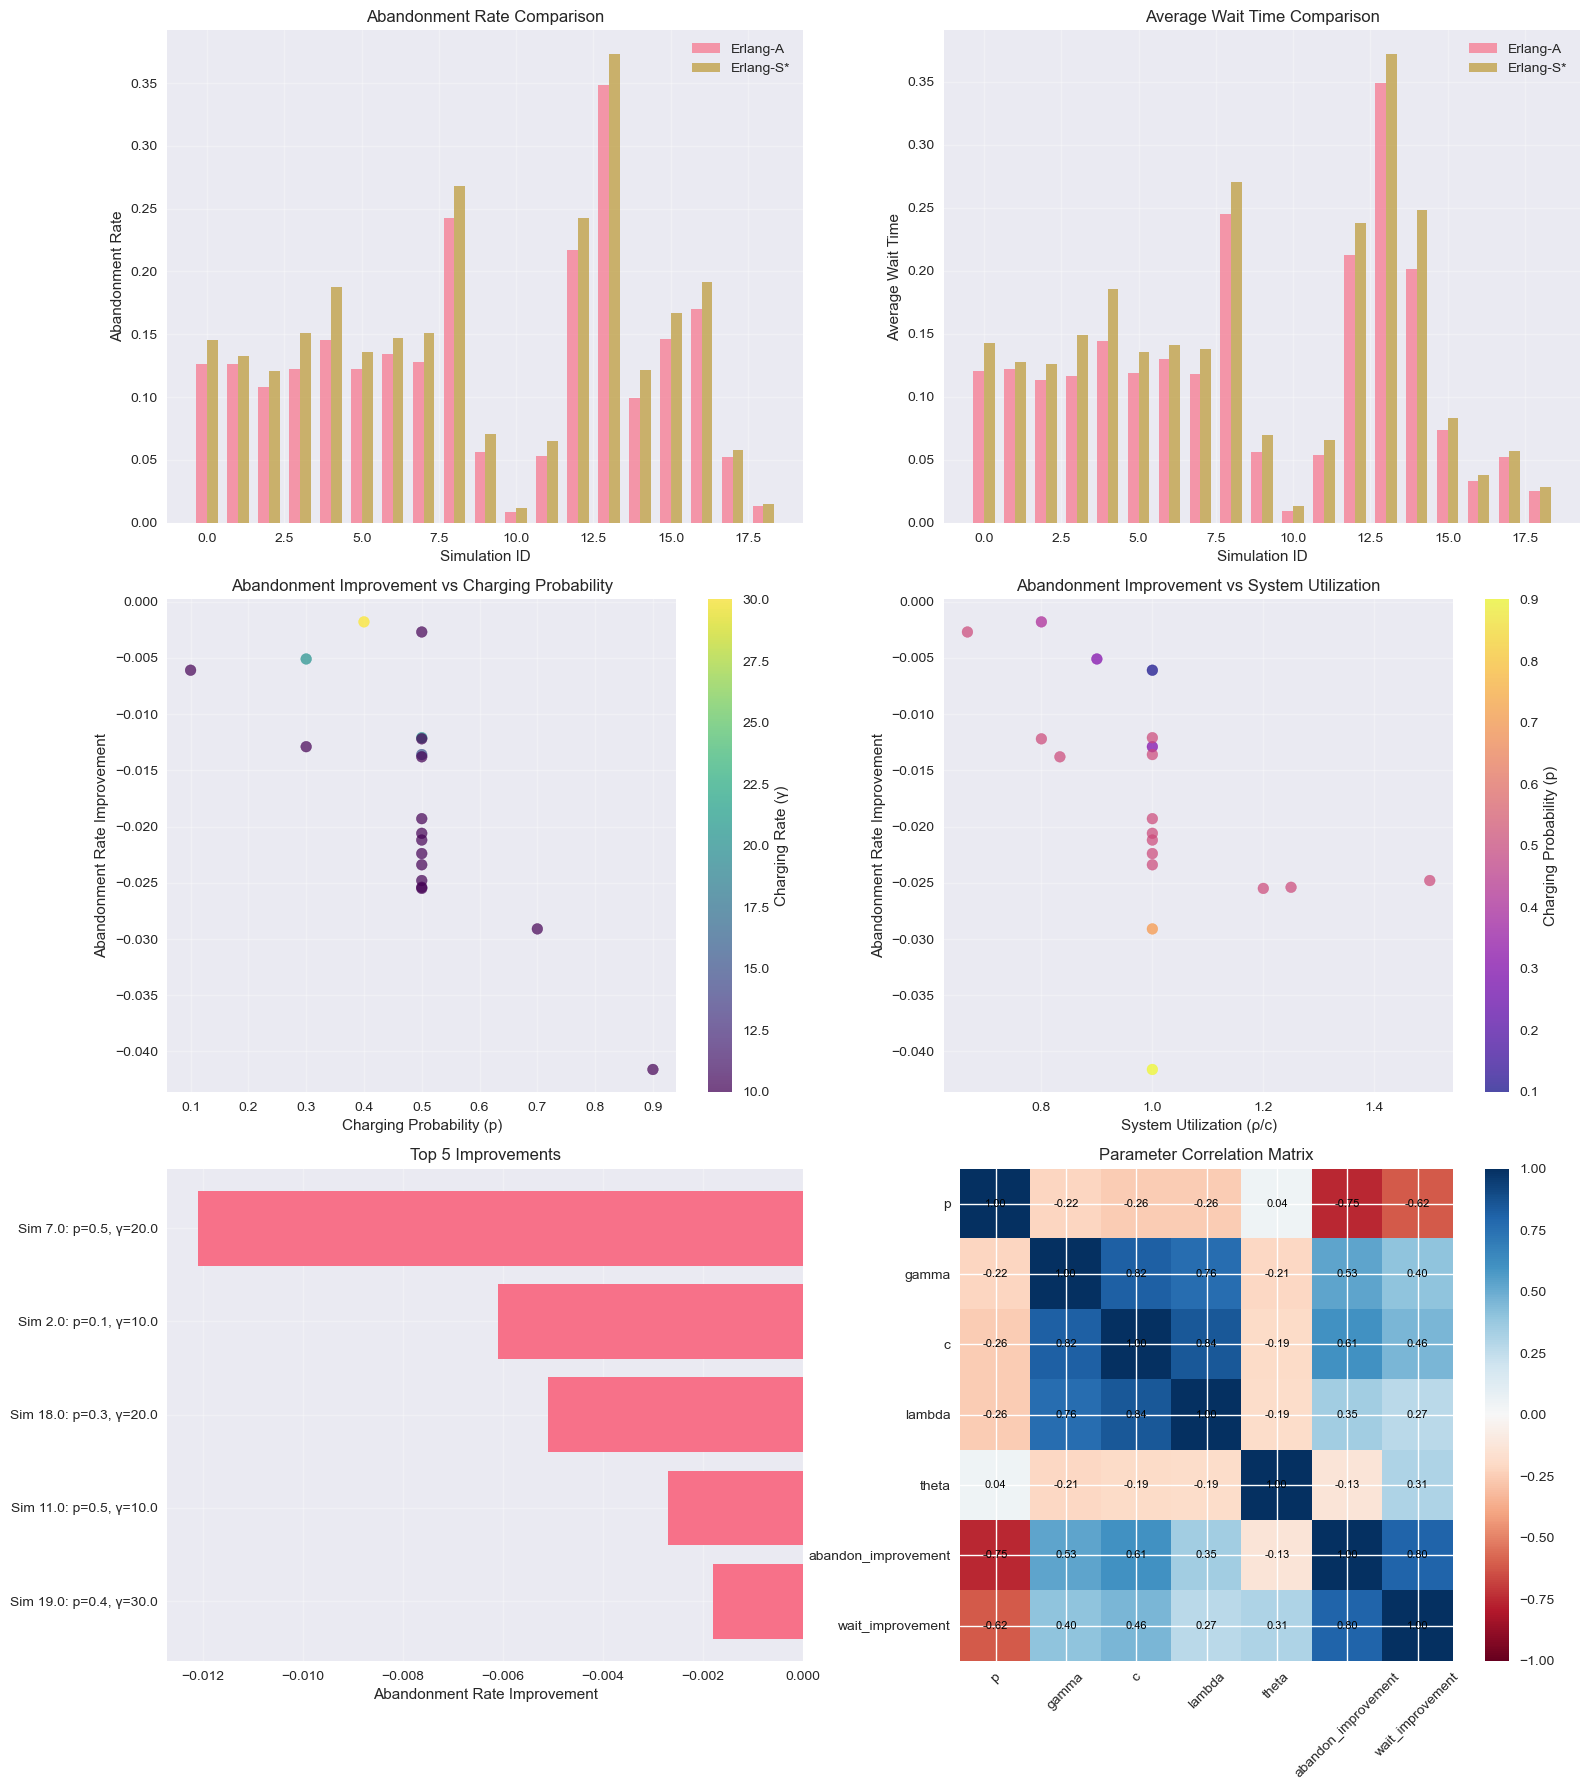

Summary saved to: simulation_results/parameter_sweep_20250721_185205/summary/parameter_sweep_summary.csv

Parameter sweep completed!
All results organized in: simulation_results/parameter_sweep_20250721_185205
Summary DataFrame shape: (19, 21)

Directory structure created:
  📁 parameter_sweep_20250721_185205/
    📄 README.md
    📁 individual_runs/ (19 simulations)
    📁 summary/ (analysis files)
    📁 plots/ (visualization files)


In [23]:
# Run the parameter sweep with organized folder structure
print("Starting organized parameter sweep...")
results, sweep_directory = run_parameter_sweep(parameter_sets, num_customers=10000)

# Analyze results and save in the same organized structure
if results:
    print("\nAnalyzing results...")
    summary_df = analyze_parameter_sweep_results(results, sweep_directory)
    
    print(f"\nParameter sweep completed!")
    print(f"All results organized in: {sweep_directory}")
    print(f"Summary DataFrame shape: {summary_df.shape}")
    
    # Print the directory structure
    print(f"\nDirectory structure created:")
    print(f"  📁 {os.path.basename(sweep_directory)}/")
    print(f"    📄 README.md")
    print(f"    📁 individual_runs/ ({len(results)} simulations)")
    print(f"    📁 summary/ (analysis files)")
    print(f"    📁 plots/ (visualization files)")
else:
    print("No successful simulations to analyze.")